# Trénovanie modelu iba na základe DST indexu 8h dopredu 6 dozadu
Súbor: 3_model_lstm_iba_dst.ipynb

Program: Hospodárska informatika

Vypracovala: Veronika Motúzová

Diplomová práca: : Predikcia geomagnetickych búrok pomocou hlbokého učenia

Vedúci diplomovej práce: doc. Ing. Peter Butka, PhD.

Konzultanti: Ing. Viera Maslej Krešňáková, RNDr. Šimon Mackovjak, PhD. 

### Inštalácia knižníc

In [1]:
!pip install pyarrow
!pip install keras
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 18.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 2.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 17.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 17.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 19.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully unin

### Kontrola kapacity servera

In [2]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


### Import knižníc

In [3]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential

from keras.layers import Dense, Activation, Dropout, Input, Conv1D, LSTM, MaxPooling1D, Flatten, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model


from scipy.special import expit, logit

from sklearn.metrics import confusion_matrix, classification_report

2022-10-23 13:53:36.320755: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-23 13:53:36.320801: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-23 13:53:36.364988: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-23 13:53:37.111096: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-23 13:53:37.111231: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: ca

### Načitanie dát, odstránenie na hodnôt, určenie predikovaného atribútu

In [4]:
df = pd.read_csv('omni_full.csv')
len(df)

520443

In [5]:
df.columns

Index(['Unnamed: 0', 'time1', 'Rot$', 'IMF', 'PLS', 'IMF_PTS', 'PLS_PTS',
       'ABS_B', 'F', 'THETA_AV', 'PHI_AV', 'BX_GSE', 'BY_GSE', 'BZ_GSE',
       'BY_GSM', 'BZ_GSM', 'SIGMA$ABS_B', 'SIGMA$B', 'SIGMA$Bx', 'SIGMA$By',
       'SIGMA$Bz', 'T', 'N', 'V', 'PHI$V', 'THETA$V', 'Ratio', 'Pressure',
       'SIGMA$T', 'SIGMA$N', 'SIGMA$V', 'SIGMA$PHI$V', 'SIGMA$THETA$V',
       'SIGMA$ratio', 'E', 'Beta', 'Mach_num', 'Mgs_mach_num', 'PR$FLX_1',
       'PR$FLX_2', 'PR$FLX_4', 'PR$FLX_10', 'PR$FLX_30', 'PR$FLX_60', 'MFLX',
       'R', 'F10_INDEX', 'KP', 'DST', 'AE', 'AP_INDEX', 'AL_INDEX', 'AU_INDEX',
       'PC_N_INDEX', 'Solar_Lyman_alpha', 'Proton_QI', 'DST+1', 'DST+2',
       'DST+3', 'DST+4', 'DST+6', 'DST+8', 'DST+12', 'DST+24'],
      dtype='object')

In [6]:
features = ['time1',
           'DST',
            'DST+8']

In [7]:
df = df[features]

In [8]:
df['time1']=pd.to_datetime(df['time1'])

In [9]:
df.dropna(inplace=True)
print(len(df))

520435


In [10]:
predicted_label = 'DST+8'

In [11]:
df.describe()

,DST,DST+8
count,520435.000000,520435.000000
mean,-14.125145,-14.125301
std,22.034976,22.034880
min,-589.000000,-589.000000
25%,-22.000000,-22.000000
50%,-10.000000,-10.000000
75%,-1.000000,-1.000000
max,81.000000,81.000000


In [12]:
df[predicted_label].describe()

count    520435.000000
mean        -14.125301
std          22.034880
min        -589.000000
25%         -22.000000
50%         -10.000000
75%          -1.000000
max          81.000000
Name: DST+8, dtype: float64

In [13]:
df.head()

,time1,DST,DST+8
8,1963-01-01 09:00:00,-2.0,-5.0
9,1963-01-01 10:00:00,-2.0,-5.0
10,1963-01-01 11:00:00,-5.0,-3.0
11,1963-01-01 12:00:00,-6.0,-3.0
12,1963-01-01 13:00:00,-8.0,-6.0


<AxesSubplot:>

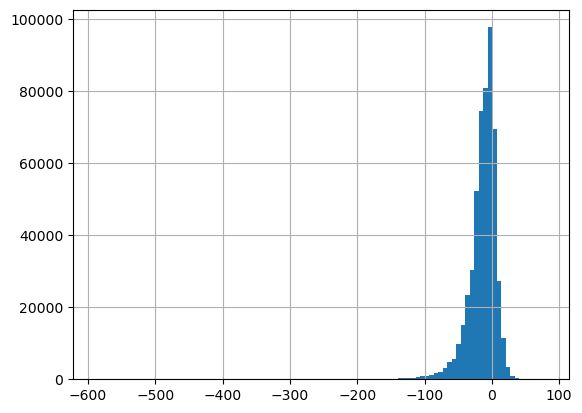

In [14]:
df[predicted_label].hist(bins=100)

In [15]:
# transform label using sigmoid
variance = df[predicted_label].std()
df["contcontinuous_transforminuous_transform"] = df[predicted_label].apply(lambda x: expit(2 * ((x - 0.2) / variance)))
df["contcontinuous_transforminuous_transform"].describe()

count    5.204350e+05
mean     3.113664e-01
std      2.271196e-01
min      5.948832e-24
25%      1.176383e-01
50%      2.837766e-01
75%      4.727973e-01
max      9.993474e-01
Name: contcontinuous_transforminuous_transform, dtype: float64

In [16]:
# choose one of them
# define y variable, i.e., what we want to predict

y_col='DST+8'
#y_col='contcontinuous_transforminuous_transform'

In [17]:
# train-test division

test_size = int(len(df) * 0.2) # here I ask that the test data will be 20% of the entire data
train = df.iloc[:-test_size,:].copy()
test = df.iloc[-test_size:,:].copy()

In [18]:
# train-validation division

valid_size = int(len(train) * 0.2) # here I ask that the test data will be 15% of the entire data
valid = train.iloc[-valid_size:,:].copy()
train = train.iloc[:-valid_size,:].copy()

In [19]:
# separate features and labels

y_train = train[y_col].values.copy()
X_train = train['DST'].values.copy()

y_val = valid[y_col].values.copy()
X_val = valid['DST'].values.copy()

y_test = test[y_col].values.copy()
X_test = test['DST'].values.copy()

In [20]:
print(y_test[0:40])

[ -5.  -4.  -7.  -9.  -9. -12. -13. -13. -12. -12. -17. -17. -15. -11.
  -8. -12. -16. -14. -14. -14. -15. -17. -13. -15. -24. -21. -17. -15.
 -17. -25. -27. -26. -27. -27. -25. -26. -20. -16. -14. -14.]


In [21]:
len(y_test)

104087

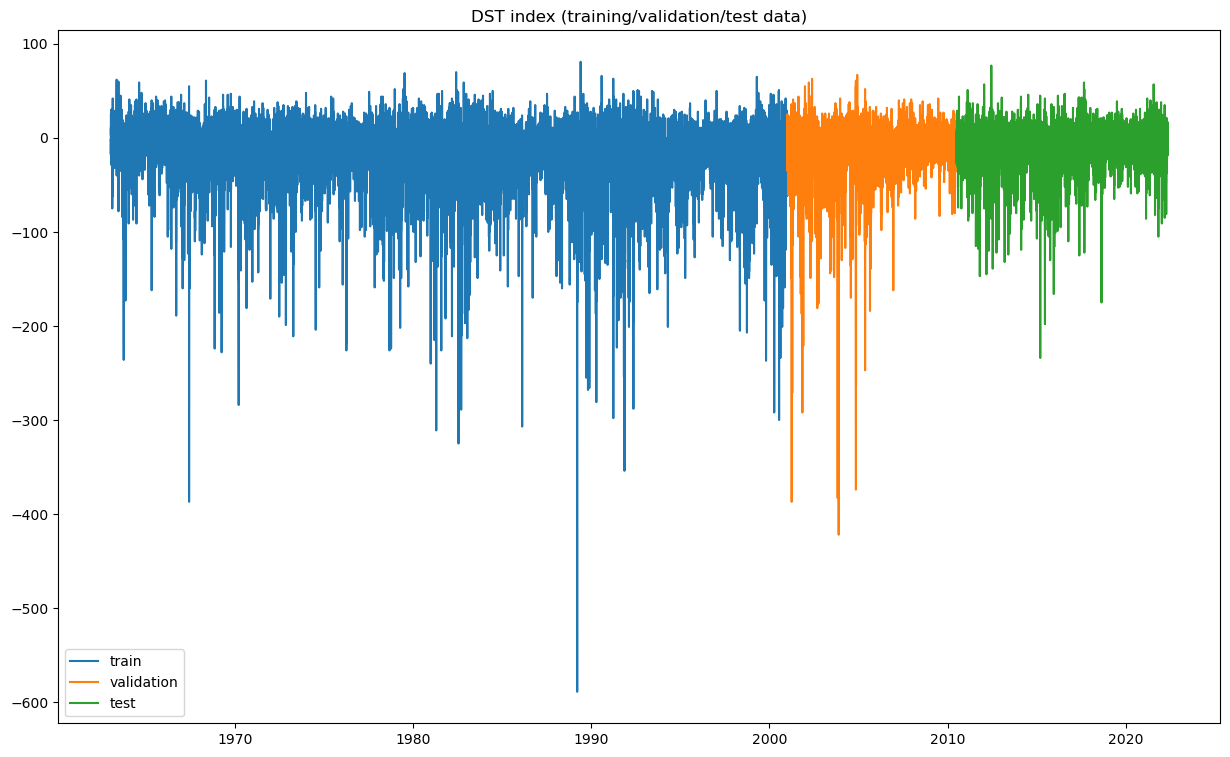

In [22]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
%matplotlib inline
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [15, 9]
plt.figure()
plt.title("DST index (training/validation/test data)")
plt.plot(train['time1'],train['DST'],label='train')
plt.plot(valid['time1'],valid['DST'],label='validation')
plt.plot(test['time1'],test['DST'],label='test')
plt.legend();

In [23]:
# set batch, n_input, n_features

n_input = 6  # how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= len(X_train)  # how many predictors/Xs/features we have to predict y
b_size = 256  # Number of timeseries samples in each batch

train_generator = TimeseriesGenerator(X_train, y_train, length=n_input, batch_size=b_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=n_input, batch_size=b_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=n_input, batch_size=256)

In [24]:
for i in range(len(test_generator)):
	x, y = test_generator[i]
	print('tt %s => %s' % (x, y))

tt [[-12. -12. -17. -17. -15. -11.]
 [-12. -17. -17. -15. -11.  -8.]
 [-17. -17. -15. -11.  -8. -12.]
 ...
 [ -4.  -2.  -3.  -5.  -6.  -4.]
 [ -2.  -3.  -5.  -6.  -4.  -5.]
 [ -3.  -5.  -6.  -4.  -5.  -8.]] => [-13. -13. -12. -12. -17. -17. -15. -11.  -8. -12. -16. -14. -14. -14.
 -15. -17. -13. -15. -24. -21. -17. -15. -17. -25. -27. -26. -27. -27.
 -25. -26. -20. -16. -14. -14. -16. -16. -15. -13. -10. -15. -18. -21.
 -22. -18. -14. -15. -18. -19. -19. -16. -16. -17. -17. -15. -18. -15.
 -13. -12. -10. -14. -16. -16. -12. -10.  -9.  -9. -13. -17. -16. -21.
 -21. -19. -19. -17. -17. -19. -18. -19. -18. -16. -16. -16. -16. -14.
 -11.  -7.  -6. -11. -19. -22. -21. -18. -15. -13. -15. -13. -13. -12.
 -12.  -9. -10. -11. -14. -13. -12.  -8.  -4.  -1.  -1.  -1.  -4.  -6.
  -9. -12. -12. -15. -19. -21. -18. -16. -12. -12. -11. -12. -15. -17.
 -17. -15. -14. -13.  -9.  -8.  -9.  -9.  -8.  -5.  -3.  -5.  -7.  -9.
 -12. -10. -11. -12. -11.  -9.  -9.  -8.  -9. -11. -10.  -8.  -3.  -3.
  -3.   0

In [25]:
print("Počet batchov: ", len(train_generator))
print("Každý batch má features (X zložku) a labels (y zložku): ", len(train_generator[0]))
print("Dĺžka X zložky batchu: ", len(train_generator[0][0]))
print("Dĺžka y zložky batchu (počet meraní v batchi): ",len(train_generator[0][1]))
print("Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu): ", len(train_generator[0][0][0]))

Počet batchov:  1302
Každý batch má features (X zložku) a labels (y zložku):  2
Dĺžka X zložky batchu:  256
Dĺžka y zložky batchu (počet meraní v batchi):  256
Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu):  6


In [26]:
inputs = Input(shape=(n_input,1))
b = Conv1D(128, kernel_size = 4, padding = "same")(inputs)
b = Bidirectional(LSTM(128, dropout=0.1,recurrent_dropout=0.1))(inputs)
b = Dense(64, activation='relu')(b)
b = Dropout(0.2)(b)
x = Dense(32, activation='relu')(b)
output = Dense(1, activation='linear')(x)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

2022-10-23 13:53:50.504729: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-23 13:53:50.504775: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-23 13:53:50.504809: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 1)]            0         
                                                                 
 bidirectional (Bidirectiona  (None, 256)              133120    
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                             

In [27]:
inputs = Input(shape=(6,1))
c = Bidirectional(LSTM(128, return_sequences=True, dropout=0.1,recurrent_dropout=0.1))(inputs)
c = LSTM(128, return_sequences=True)(c)
c = TimeDistributed(Dense(1, activation='linear'))(c)
output = Flatten()(c)
output = Dense(1, activation='linear')(output)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6, 1)]            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 6, 256)           133120    
 nal)                                                            
                                                                 
 lstm_2 (LSTM)               (None, 6, 128)            197120    
                                                                 
 time_distributed (TimeDistr  (None, 6, 1)             129       
 ibuted)                                                         
                                                                 
 flatten (Flatten)           (None, 6)                 0         
                                                                 
 dense_4 (Dense)             (None, 1)                 7   

In [28]:
# callbacks
saved_model = "6_dozadu_8_dopredu.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_mae', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_mae", mode="min", patience=25)
callbacks_list = [checkpoint, early]

In [29]:
# fit
history = model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=1, callbacks = callbacks_list)

Epoch 1/20
1301/1302 [============================>.] - ETA: 0s - loss: 108.5687 - mae: 5.9075
Epoch 1: val_mae improved from inf to 4.68294, saving model to 6_dozadu_8_dopredu.hdf5
1302/1302 [==============================] - 99s 72ms/step - loss: 108.5348 - mae: 5.9077 - val_loss: 70.8042 - val_mae: 4.6829
Epoch 2/20
1302/1302 [==============================] - ETA: 0s - loss: 69.8136 - mae: 5.2236
Epoch 2: val_mae improved from 4.68294 to 4.41923, saving model to 6_dozadu_8_dopredu.hdf5
1302/1302 [==============================] - 91s 70ms/step - loss: 69.8136 - mae: 5.2236 - val_loss: 59.0260 - val_mae: 4.4192
Epoch 3/20
1301/1302 [============================>.] - ETA: 0s - loss: 66.2075 - mae: 5.1430
Epoch 3: val_mae did not improve from 4.41923
1302/1302 [==============================] - 91s 70ms/step - loss: 66.2105 - mae: 5.1435 - val_loss: 60.5475 - val_mae: 4.6477
Epoch 4/20
1301/1302 [============================>.] - ETA: 0s - loss: 65.3757 - mae: 5.1353
Epoch 4: val_mae 

In [30]:
# load best model
model = keras.models.load_model('6_dozadu_8_dopredu.hdf5')

In [31]:
# prediction
y_pred = model.predict(test_generator)

407/407 [==============================] - 9s 19ms/step


In [32]:
y_pred

array([[-13.23744  ],
       [-10.610177 ],
       [-16.451868 ],
       ...,
       [  8.851713 ],
       [  6.1051664],
       [  5.785102 ]], dtype=float32)

In [33]:
# confusion matrix
# TN FP
# FN TP

y_pred2 = np.where(y_pred <= -20, 1, 0)
# [n_input:] because prediction starts from n-th row
y_test2 = np.where(y_test[n_input:]  <= -20, 1, 0)

cm = confusion_matrix(y_test2, y_pred2)
print("Confusion matrix: \n" + str(cm))

Confusion matrix: 
[[80454  2911]
 [ 3918 16798]]


In [34]:
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     83365
           1       0.85      0.81      0.83     20716

    accuracy                           0.93    104081
   macro avg       0.90      0.89      0.90    104081
weighted avg       0.93      0.93      0.93    104081



In [35]:
df = pd.DataFrame(data={"time": test['time1'][n_input:],"y_true": y_test[n_input:].reshape(-1) , "y_predict": y_pred.reshape(-1)})

In [36]:
df

,time,y_true,y_predict
416362,2010-06-29 12:00:00,-13.0,-13.237440
416363,2010-06-29 13:00:00,-13.0,-10.610177
416364,2010-06-29 14:00:00,-12.0,-16.451868
416365,2010-06-29 15:00:00,-12.0,-16.520348
416366,2010-06-29 16:00:00,-17.0,-15.511766
...,...,...,...
520438,2022-05-13 12:00:00,12.0,9.010632
520439,2022-05-13 13:00:00,11.0,5.466376
520440,2022-05-13 14:00:00,11.0,8.851713
520441,2022-05-13 15:00:00,9.0,6.105166


In [37]:
df.describe()

,y_true,y_predict
count,104081.000000,104081.000000
mean,-9.642125,-10.046894
std,16.039791,14.889833
min,-234.000000,-199.262543
25%,-17.000000,-16.605623
50%,-7.000000,-7.259696
75%,0.000000,-0.314371
max,77.000000,36.178921


<AxesSubplot:>

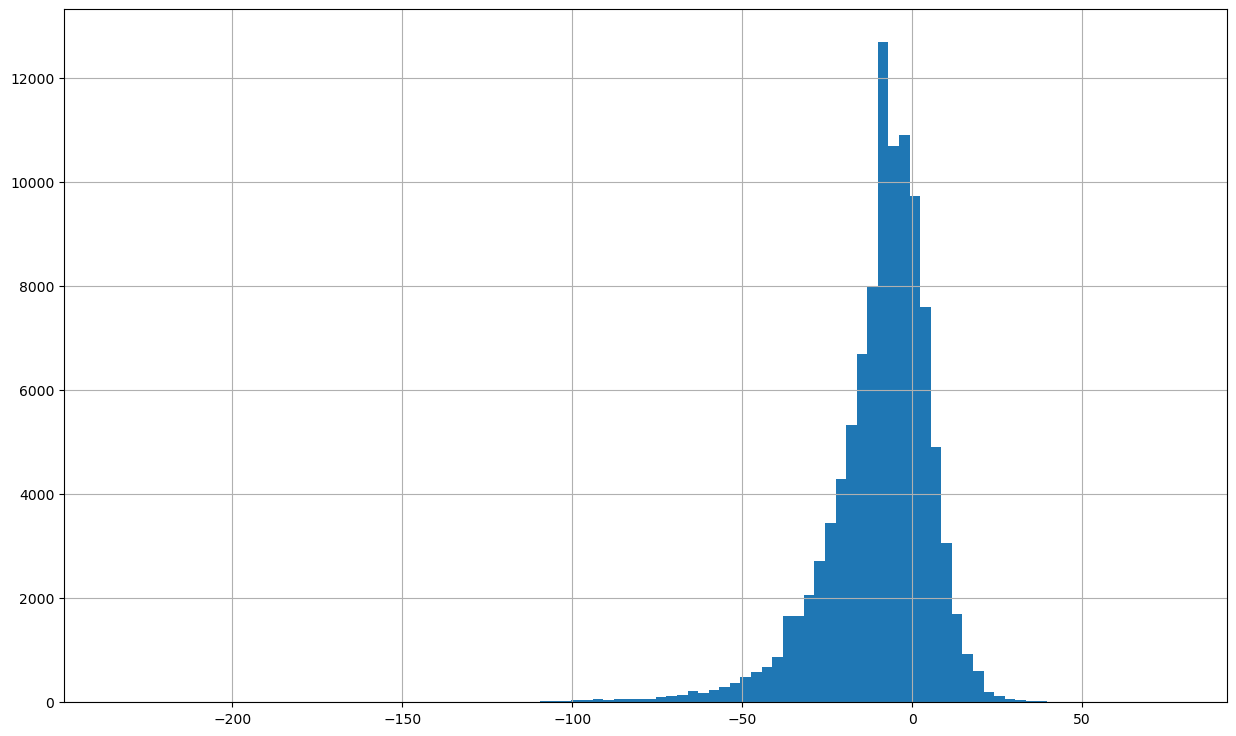

In [38]:
df["y_true"].hist(bins=100)

<AxesSubplot:>

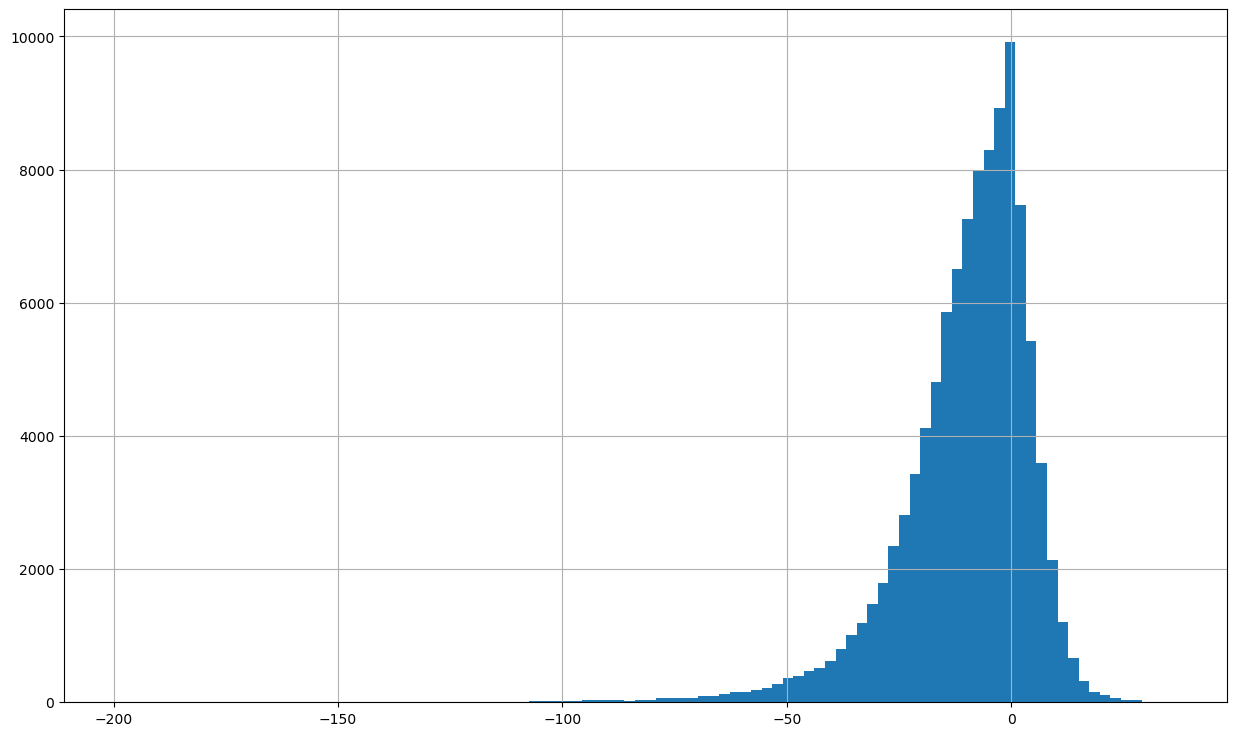

In [39]:
df["y_predict"].hist(bins=100)

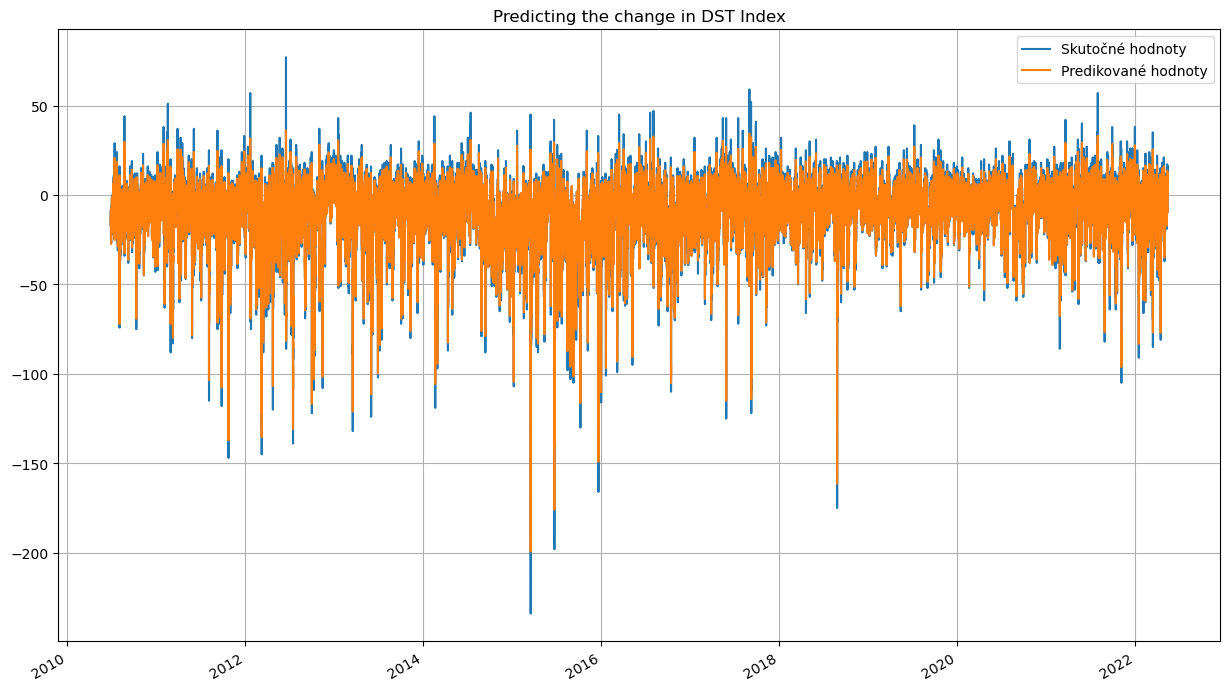

In [40]:
plt.figure()
plt.title('Predicting the change in DST Index')
plt.plot(df['time'],df['y_true'], label='Skutočné hodnoty')
plt.plot(df['time'],df['y_predict'], label='Predikované hodnoty')
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(True)

In [41]:
df.to_csv('predikcie_6h_dozadu_8h_dopredu.csv')